<h1>Содержание<span class="tocSkip"></span></h1>


# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

**Цель исследования**

Проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Проверить гипотезы:

средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Описание данных**

**Таблица users (информация о пользователях):**

user_id — уникальный идентификатор пользователя

first_name — имя пользователя

last_name — фамилия пользователя

age — возраст пользователя (годы)

reg_date — дата подключения тарифа (день, месяц, год)

churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал 
на момент выгрузки данных)

city — город проживания пользователя

tarif — название тарифного плана

**Таблица calls (информация о звонках):**

id — уникальный номер звонка

call_date — дата звонка

duration — длительность звонка в минутах

user_id — идентификатор пользователя, сделавшего звонок


**Таблица messages (информация о сообщениях):**

id — уникальный номер сообщения

message_date — дата сообщения

user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

id — уникальный номер сессии

mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)

session_date — дата интернет-сессии

user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

tariff_name — название тарифа

rub_monthly_fee — ежемесячная абонентская плата в рублях

minutes_included — количество минут разговора в месяц, включённых в абонентскую плату

messages_included — количество сообщений в месяц, включённых в абонентскую плату

mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 
минут разговора в месяц, то со 101 минуты будет взиматься плата)

rub_per_message — стоимость отправки сообщения сверх тарифного пакета

rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файла

In [ ]:
import pandas as pd
from pymystem3 import Mystem
m = Mystem()
from collections import Counter
import matplotlib.pyplot as plt
from math import factorial
from scipy import stats as st
import numpy as np
import seaborn

In [ ]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Нужно в столбце call_date заменить тип данных на date_time

In [ ]:
internet = pd.read_csv('/datasets/internet.csv', index_col=0 )
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


в таблице internet находится столбец Unnamed: 0, отражающий индексацию. чтобы использовать индекс, укажем аргумент index_col=0

In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Заменить тип данных в столбце session_date

In [ ]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [ ]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [ ]:
users = pd.read_csv('/datasets/users.csv')
users.tail()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [ ]:
users.describe().round()

,user_id,age
count,500.0,500.0
mean,1250.0,47.0
std,144.0,17.0
min,1000.0,18.0
25%,1125.0,32.0
50%,1250.0,46.0
75%,1374.0,62.0
max,1499.0,75.0


В столбце reg_date — дата подключения тарифа (день, месяц, год) нужно заменить тип данных на date_time.

В столбце churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных) довольно много пропущенных значений.

Посмотрели все датасеты. Теперь заменим типы данных.

## Преподготовка данных

Посчитаем доли пропусков в таблице пользователи.

In [ ]:
users.isna().mean().apply('{:.0%}'.format)

user_id        0%
age            0%
churn_date    92%
city           0%
first_name     0%
last_name      0%
reg_date       0%
tariff         0%
dtype: object

Мы видим пропуски только в одном столбце churn_date, целых 92%. Но как указано, пропущенные значения означают, что на момент выгрузки данных тариф еще действовал. 

### Замена типа данных

In [ ]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [ ]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [ ]:
calls['id'] = calls['id'].astype('int')

In [ ]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

In [ ]:
calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000


In [ ]:
calls = calls.query('duration != 0')

In [ ]:
calls.describe()

,id,duration,user_id
count,1.629940e+05,162994.000000,162994.000000
mean,1.212660e+06,8.897880,1254.149877
std,1.728141e+06,5.353761,144.751050
min,1.000200e+04,1.000000,1000.000000
25%,1.012247e+06,5.000000,1126.000000
50%,1.179350e+06,8.000000,1261.000000
75%,1.358215e+06,12.000000,1379.000000
max,1.458115e+07,38.000000,1499.000000


In [ ]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [ ]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


**Вывод**

Заменили типы данных в таблицах, в таблице "звонки" округлили значения в большую сторону, а также видим нулевые значения, нулями обозначены пропущенные звонки, поэтому их не будем удалять.

### Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя

In [ ]:
calls['month'] = calls['call_date'].dt.month_name()

In [ ]:
#calls.head()

#user_calls = calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})

In [ ]:
calls_pivot = calls.pivot_table(index=['user_id', 'month'],
                                values='duration', aggfunc=("sum",'count')).reset_index()

calls_pivot.columns = ('user_id', 'month', 'calls_count', 'mins')
calls_pivot

,user_id,month,calls_count,mins
0,1000,August,42,408
1,1000,December,38,333
2,1000,July,41,340
3,1000,June,28,172
4,1000,May,17,159
...,...,...,...,...
3163,1498,September,53,471
3164,1499,December,56,492
3165,1499,November,62,612
3166,1499,October,44,449


In [ ]:
#user_calls.head()

### Количество отправленных сообщений по месяцам

In [ ]:
messages['month'] = messages['message_date'].dt.month_name()

In [ ]:
#messages.head()

#user_messages = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'sms_total_in_month'})

In [ ]:
#user_messages.head()

In [ ]:
messages_pivot = messages.pivot_table(index=['user_id','month'],
                                      values='message_date', aggfunc=('count')).reset_index()

messages_pivot.columns = ('user_id', 'month', 'messages_count')
messages_pivot

,user_id,month,messages_count
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22
...,...,...,...
2712,1498,September,44
2713,1499,December,66
2714,1499,November,59
2715,1499,October,48


### Oбъем израсходованного интернет-трафика по месяцам

In [ ]:
internet['month'] = internet['session_date'].dt.month_name()

In [ ]:
#internet.head()

#user_internet = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'mb_total_in_month'})

In [ ]:
#user_internet.head()

In [ ]:
internet_pivot = internet.pivot_table(index=['user_id','month'],
                                      values='mb_used', aggfunc=('sum')).reset_index()

internet_pivot.head()

,user_id,month,mb_used
0,1000,August,14055.93
1,1000,December,9817.61
2,1000,July,14003.64
3,1000,June,23233.77
4,1000,May,2253.49


### Помесячная выручка с каждого пользователя 

In [ ]:
tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

In [ ]:
data_merge = calls_pivot.merge(messages_pivot, on=('user_id', 'month'), how='outer')
data_merge = data_merge.merge(internet_pivot, on=('user_id', 'month'), how='outer')
data_merge = data_merge.merge(users, on=('user_id'), how='left')
data_merge = data_merge.merge(tariffs, on=('tariff'), how='left')
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
user_id                  3214 non-null int64
month                    3214 non-null object
calls_count              3168 non-null float64
mins                     3168 non-null float64
messages_count           2717 non-null float64
mb_used                  3203 non-null float64
age                      3214 non-null int64
churn_date               187 non-null datetime64[ns]
city                     3214 non-null object
first_name               3214 non-null object
last_name                3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_

Появились пропуски, заполним их 0 и заменим тип данных.

In [ ]:
for col in ['calls_count', 'mins', 'messages_count','mb_used']:
    data_merge[col] = data_merge[col].fillna(0).astype(int)
data_merge.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
user_id                  3214 non-null int64
month                    3214 non-null object
calls_count              3214 non-null int64
mins                     3214 non-null int64
messages_count           3214 non-null int64
mb_used                  3214 non-null int64
age                      3214 non-null int64
churn_date               187 non-null datetime64[ns]
city                     3214 non-null object
first_name               3214 non-null object
last_name                3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute  

In [ ]:
def profit_calculation(df):
    df['profit'] = df['rub_monthly_fee']
    if df['mins'] > df['minutes_included']:
        df['profit'] += (df['mins'] - df['minutes_included']) * df['rub_per_minute']
    if df['messages_count'] > df['messages_included']:
        df['profit'] += (df['messages_count'] - df['messages_included']) * df['rub_per_message']
    if df['mb_used'] > df['mb_per_month_included']:
        df['profit'] += (np.ceil(df['mb_used'] / 1024) - df['mb_per_month_included'] / 1024) * df['rub_per_gb']    
    return df   

In [ ]:
data_merge = data_merge.apply(profit_calculation, axis=1)
data_merge['profit'] = data_merge['profit'].astype(int)
data_merge = data_merge.drop(['first_name', 'last_name', 'messages_included', 'mb_per_month_included','minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute'], axis=1)
data_merge.columns

Index(['user_id', 'month', 'calls_count', 'mins', 'messages_count', 'mb_used',
       'age', 'churn_date', 'city', 'reg_date', 'tariff', 'profit'],
      dtype='object')

Расчитали количество звонков, сообщений и израсходованного интернет трафика по месяцам для каждого польователя, а также помесячную выручку с каждого пользователя. 

## Анализ данных

In [ ]:
data_merge

,user_id,month,calls_count,mins,messages_count,mb_used,age,churn_date,city,reg_date,tariff,profit
0,1000,August,42,408,81,14055,52,NaT,Краснодар,2018-05-25,ultra,1950
1,1000,December,38,333,70,9817,52,NaT,Краснодар,2018-05-25,ultra,1950
2,1000,July,41,340,75,14003,52,NaT,Краснодар,2018-05-25,ultra,1950
3,1000,June,28,172,60,23233,52,NaT,Краснодар,2018-05-25,ultra,1950
4,1000,May,17,159,22,2253,52,NaT,Краснодар,2018-05-25,ultra,1950
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,November,0,0,20,17491,35,NaT,Санкт-Петербург,2018-08-15,smart,1150
3210,1489,October,0,0,21,19559,35,NaT,Санкт-Петербург,2018-08-15,smart,1550
3211,1489,September,0,0,32,17206,35,NaT,Санкт-Петербург,2018-08-15,smart,950
3212,1240,February,0,0,0,959,30,NaT,Воронеж,2018-02-27,ultra,1950


In [ ]:
def func_pivot(value):
    table = data_merge.pivot_table(index=('tariff'), values=value,\
                       aggfunc=('median','mean','var','std')).astype(int).reset_index()
    return table

In [ ]:
mins_pivot = func_pivot('mins')
mins_pivot

,tariff,mean,median,std,var
0,smart,417,422,190,36219
1,ultra,526,518,317,100873


In [ ]:
messages_pivot = func_pivot('messages_count')
messages_pivot

,tariff,mean,median,std,var
0,smart,33,28,28,796
1,ultra,49,38,47,2285


In [ ]:
internet_pivot = func_pivot('mb_used')
internet_pivot

,tariff,mean,median,std,var
0,smart,16207,16506,5870,34462537
1,ultra,19468,19308,10087,101751075


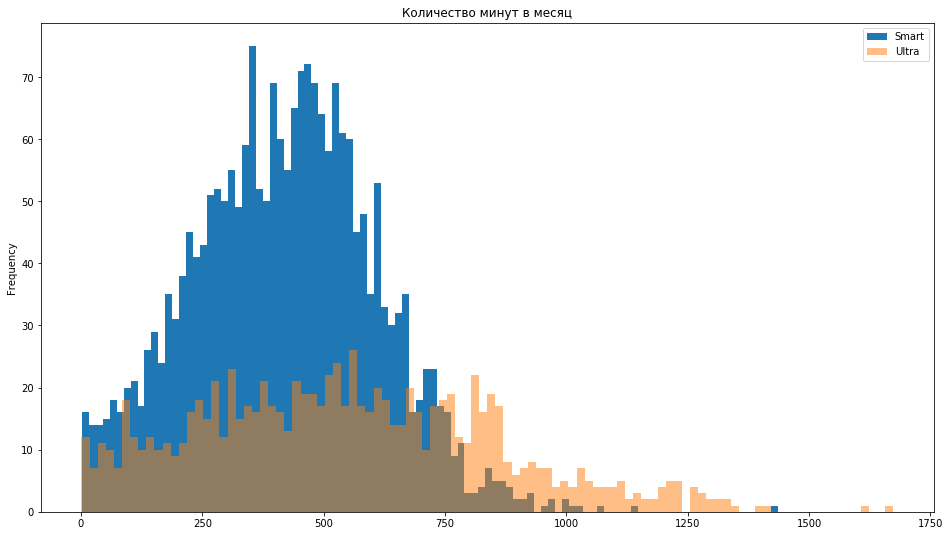

In [ ]:
data_merge[(data_merge['tariff'] == 'smart')
           & (data_merge['mins'] !=0)]['mins'].plot(kind='hist', bins=100, title='Количество минут в месяц', figsize=(16, 9))

data_merge[(data_merge['tariff'] == 'ultra')
           & (data_merge['mins'] !=0)]['mins'].plot(kind='hist', bins=100, alpha = 0.5)

plt.legend(["Smart", "Ultra"])

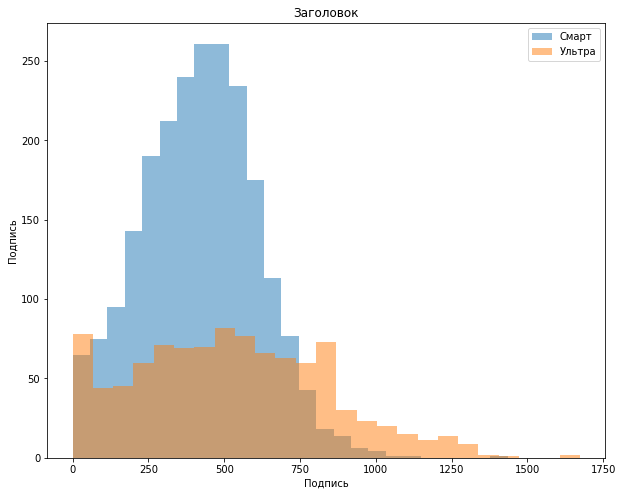

In [ ]:
data_merge.groupby('tariff')['mins'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Смарт', 'Ультра'])
plt.title('Заголовок')
plt.xlabel('Подпись')
plt.ylabel('Подпись')

plt.show()

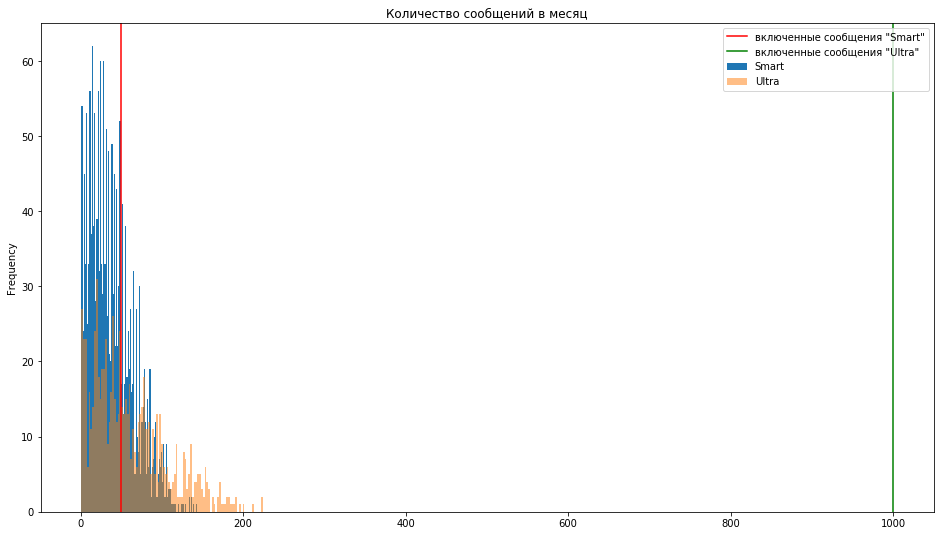

In [ ]:
data_merge[(data_merge['tariff'] == 'smart')
           & (data_merge['messages_count'] !=0)]['messages_count'].plot(
    kind='hist', bins=100, title='Количество сообщений в месяц', figsize=(16, 9))

data_merge[(data_merge['tariff'] == 'ultra')
           & (data_merge['messages_count'] !=0)]['messages_count'].plot(
    kind='hist', bins=100, alpha = 0.5)

plt.axvline(x=50, color='r')
plt.axvline(x=1000, color='g')
plt.legend(['включенные сообщения "Smart"', 'включенные сообщения "Ultra"', "Smart", "Ultra"], loc=1)

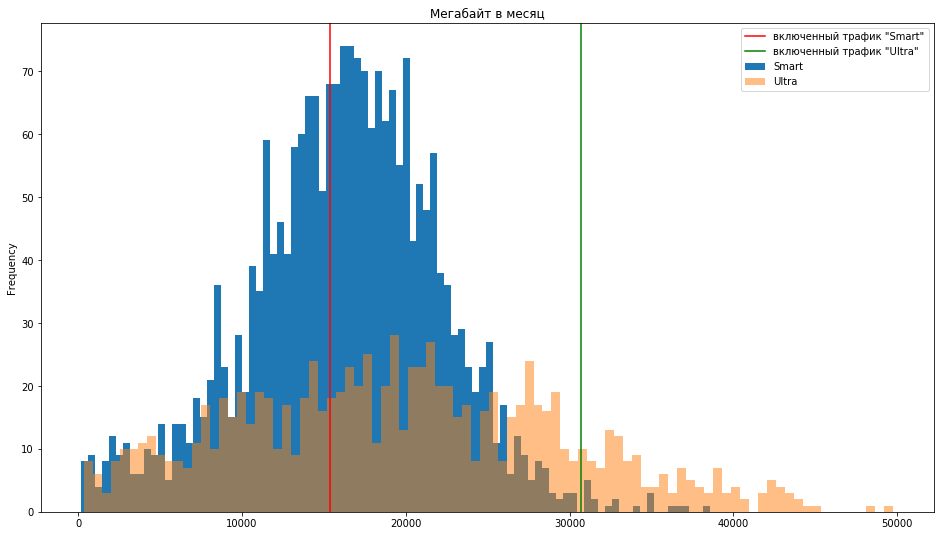

In [ ]:
data_merge[(data_merge['tariff'] == 'smart')
           &(data_merge['mb_used'] !=0)]['mb_used'].plot(kind='hist', bins=90, title='Мегабайт в месяц', figsize=(16, 9))

data_merge[(data_merge['tariff'] == 'ultra')
           &(data_merge['mb_used'] !=0)]['mb_used'].plot(kind='hist', bins=90, alpha = 0.5)

plt.axvline(x=15360, color='r')
plt.axvline(x=30720, color='g')
plt.legend(['включенный трафик "Smart"', 'включенный трафик "Ultra"', "Smart", "Ultra"], loc=1)

**Вывод**

Исходя из приведенных графиков заметно, что распределение литимов по тарифу "Смарт" не укладывается в рамки трафика ни по одному из параметров. По тарифу "Ультра" распределения минут разговра и смс находятся в пределах указанных лимитов по тарифу, по трафику - уже выходит чуть дальше рамок.

## Проверка гипотез

Н0  - средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковы

Н1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

alpha = 0.05

In [ ]:
df_smart = data_merge[data_merge['tariff'] == 'smart']
df_ultra = data_merge[data_merge['tariff'] == 'ultra']
alpha = 0.05

result = st.ttest_ind(df_smart['profit'], df_ultra['profit'])

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Нулевая гипотеза не подтвердилась, а значит с большой вероятностью мы можем говорить о том что пользователи тарифа "Ultra" приносят больше денег компании.

Несмотря на то, что тариф "Ультра" стоит дороже, чем "Смарт", пользователям "Смарт" не всегда хватает имеющегося лимита и им просто приходится переплачивать. Поэтому выручки по этим тарифам существенно отличаются.

Перейдем к следующей гипотезе.

Н0  - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов

Н1 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

alpha = 0.05

In [ ]:
df_moscow = data_merge[data_merge['city'] == 'Москва']
df_another_city = data_merge[data_merge['city'] != 'Москва']

abs(np.mean(df_moscow ['profit']) - np.mean(df_another_city['profit'])) / (np.var(df_another_city['profit']))

3.330449950696979e-05

In [ ]:
alpha = 0.05

result = st.ttest_ind(df_moscow ['profit'], df_another_city['profit'])

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергнута, а значит пользователи из Москвы тратят столько же сколько пользователи из других городов.

## Общий вывод


Изучили данные 500 клиентов, которые используют тарифы "Смарт" и "Ультра" и произвели предобработку (изменили тип некоторых данных, округлили значения минут и мегабайтов в большую сторону, обработали нулевые значения)

Для каждого пользователя рассчитали количество звонков, сообщений и израсходованного интернет трафика по месяцам, а также помесячную выручку

Проанализировав данные о выручках по каждому тарифу и выяснили, что пользователям тарифа «Смарт» не хватает лимита в рамках тарифного пакета, из-за этого клиенты "Смарта" в год приносят больше выручки для компании, чем клиенты "Ультра"

Произвели статистический анализ и проверили 2 гипотезы:

средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
Получили следующее:

Несмотря на то, что тариф "Ультра" стоит дороже, чем "Смарт", пользователям "Смарт" не всегда хватает имеющегося лимита и им просто приходится переплачивать. Поэтому выручки по этим тарифам существенно отличаются, по "Смарту" она больше.

Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. 

Можем сделать вывод, что с точки зрения прибыли тариф "Смарт" будет лучше, чем тариф "Ультра"